In [1]:
!bedtools intersect -v -a CAP-CGI_hg19.bed -b ENCFF391AYY_H3K27me3_HAP1_hg19.bed \
| bedtools sort -i | bedtools merge \
> CAP-CGI_noH3K27me3_HAP1_hg19.bed

In [2]:
!wget https://raw.githubusercontent.com/ggirelli/GPSeq-source-data/master/figures/fig-02/fig-02-e.tsv -q -O GPseq_fig2e.tsv

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bioframe as bf

In [4]:
GPseq = pd.read_table("GPseq_fig2e.tsv", sep="\t")

In [5]:
GPseq.head()

,resolution,chrom,start,end,exp1,exp2
0,100kb,chr1,700000,800000,0.880398,NaN
1,100kb,chr1,800000,900000,0.328710,0.439071
2,100kb,chr1,900000,1000000,0.897176,0.779219
3,100kb,chr1,1000000,1100000,0.958774,0.939078
4,100kb,chr1,1300000,1400000,0.830566,0.916534


In [6]:
GPseq["avg"] = np.nanmean([GPseq["exp1"], GPseq["exp2"]], axis=0)

In [7]:
GPseq.loc[GPseq["avg"] <= np.quantile(GPseq["avg"], 0.33), "third"] = 1
GPseq.loc[GPseq["avg"] > np.quantile(GPseq["avg"], 0.33), "third"] = 2
GPseq.loc[GPseq["avg"] > np.quantile(GPseq["avg"], 0.66), "third"] = 3

In [8]:
CAP_CGI_noH3K27me3 = pd.read_csv("CAP-CGI_noH3K27me3_HAP1_hg19.bed", sep="\t", header=None)
CAP_CGI_noH3K27me3.columns = ["chrom", "start", "end"]

In [9]:
CAP_CGI_noH3K27me3 = bf.overlap(GPseq, CAP_CGI_noH3K27me3, suffixes=["", "_CGI"])

In [10]:
CAP_CGI_noH3K27me3 = CAP_CGI_noH3K27me3.dropna()

In [11]:
GPseq_CGI_dist = pd.DataFrame(CAP_CGI_noH3K27me3.groupby("third").size()).reset_index()
GPseq_CGI_dist.columns = ["bin", "count"]
GPseq_CGI_dist["bin"] = GPseq_CGI_dist["bin"].astype(int)
GPseq_CGI_dist

,bin,count
0,1,2670
1,2,4534
2,3,10009


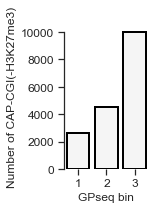

In [12]:
plt.figure(figsize=(2, 2.5))
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":16, 
                                "axes.labelsize": 12, "xtick.labelsize": 12,
                                "ytick.labelsize": 12})   
g = sns.barplot(data=GPseq_CGI_dist, x="bin", y="count", 
                edgecolor='black', color="whitesmoke", linewidth=2)
g.set(xlabel="GPseq bin", title="", ylabel="Number of CAP-CGI(-H3K27me3)")
plt.tight_layout()
sns.despine(trim=True, bottom=True)
plt.savefig("plots/CGI_GPseq.svg")

In [13]:
for i in range(3):
    CAP_CGI_noH3K27me3.loc[CAP_CGI_noH3K27me3["third"] == i+1, 
                           ["chrom_CGI", 
                            "start_CGI", 
                            "end_CGI"]].sample(2670, 
                                               random_state=5).sort_values(["chrom_CGI", 
                                                                            "start_CGI"]).to_csv(f"GPseq_third_{i+1}_hg19_CAP-CGI_noH3K27me3_HAP1.bed",
                                                                                                 sep="\t", 
                                                                                                 index=False, 
                                                                                                 header=None)